# Сборный проект-5

Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## 1. Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 2. Загрузка необходмых библиотек и данных

In [1]:
!pip install tensorflow -q
!pip install torch -q
!pip install torchvision -q
!pip install transformers -q

In [2]:
# Загрузка библиотек
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product
import textwrap

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [3]:
# Загрузка данных

train = pd.read_csv('train_dataset.csv')
display(train.head())
train.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [4]:
crwd = pd.read_csv('CrowdAnnotations.tsv', sep='\t', header = None,
           names = ['image','query_id','true_share','crwd_true','crwd_false'])

display(crwd.head())
crwd.info()

,image,query_id,true_share,crwd_true,crwd_false
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       47830 non-null  object 
 1   query_id    47830 non-null  object 
 2   true_share  47830 non-null  float64
 3   crwd_true   47830 non-null  int64  
 4   crwd_false  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [5]:
crwd.merge(train, on = ['image','query_id'], how = 'left')#.info()     #[crwd[['image','query_id']].isin(train[['image','query_id']])]

,image,query_id,true_share,crwd_true,crwd_false,query_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,NaN
...,...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3,NaN
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2,NaN
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0,NaN
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3,NaN


In [6]:
experts = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header = None,
           names = ['image','query_id','exp1','exp2','exp3'])

display(experts.head())
experts.info()

,image,query_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp1      5822 non-null   int64 
 3   exp2      5822 non-null   int64 
 4   exp3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


Данные загрузились корерктно, форматы данных определелились правильно.

## 3. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 

Для того, чтобы получить единую оценку эксперта мы воспользуемся следующим алгоритмом:
* Рассчитаем моду (самое частое) оценок экспертов. Также отобразим частоту моды. Если частота моды больше 1, значит хотя бы 2 эксперта поставили одинаковую оценку и мы считаем такую оценку валидной.
* Если частота моды равна 1, значит все эксперты дали разные оценки. В таком случае мы считаем данную пару "изображение-описание" невалидной и удаляем из набора данных.

Далее, полученную экспертную оценку необходимо перевести в разрвер "вероятности соответствия описания картинке". Учитывая, что градация состоит из 4 логичных ступеней соответствия, предлагаем использовать дискретную шкалу из четырех значений вероятность 0%, 33% , 67% и 100%. 

In [7]:
experts[['mode_expert','mode_frequency']] = pd.DataFrame(stats.mode(experts[['exp1','exp2','exp3']], axis = 1)).T

experts = experts[experts['mode_frequency']!=1][['image','query_id','mode_expert']].reset_index(drop=True)

experts['expert_prob'] = np.where(experts['mode_expert']==1 , 0,
                                 np.where(experts['mode_expert']==2 , 0.33,
                                          np.where(experts['mode_expert']==3 , 0.67 , 1)))

experts.head()

,image,query_id,mode_expert,expert_prob
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,0.00
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,0.00
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,0.00
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,2,0.33
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,0.00


Так, мы получили агрегированые оценки экспертов.

Далее перейдем к оценкам краудсорсинга.
В целом, естественным образом нам подходит оценка true_share - вероятность того, что изображение соответствует описанию, рассчитанная эмпирически как кол-во ответов "соответствует" деленное на общее кол-во ответов.  
Однако, имея все исходные данные, пересчитаем данную величину самостоятельно, чтобы удостовериться, что изображения с true_share = 0 соответствуют записям со всеми ответами "не соответствует", а не, например, с нулевым количеством ответов.

In [8]:
crwd['count'] = crwd['crwd_true']+crwd['crwd_false']
crwd['crwd_prob'] = crwd['crwd_true']/crwd['count']

In [9]:
crwd.describe()

,true_share,crwd_true,crwd_false,count,crwd_prob
count,47830.000000,47830.000000,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155,3.028643,0.068786
std,0.207532,0.628898,0.656676,0.208075,0.207532
min,0.000000,0.000000,0.000000,3.000000,0.000000
25%,0.000000,0.000000,3.000000,3.000000,0.000000
50%,0.000000,0.000000,3.000000,3.000000,0.000000
75%,0.000000,0.000000,3.000000,3.000000,0.000000
max,1.000000,5.000000,6.000000,6.000000,1.000000


Действительно видим, что для всех пар "изображение-описание" присутствует как минимум 3 оценки краудсорсинга, а значит величина crwd_prob может быть использована корректно. Будем использовать ее в качестве агрегированной вероятности того, что описание соответствует изображению.

Теперь, необходимо собрать в один набор данных датасет train с парами изображение - описание из обучающей выборки, а также оценки вероятности соответствия от экспертов и из краудсорсинга.

In [10]:
train_w_target = (train.merge(experts[['image','query_id','expert_prob']], how = 'left', on = ['image','query_id'])
                       .merge(crwd[['image','query_id','crwd_prob']], how = 'left', on = ['image','query_id']))
                    

In [11]:
train_w_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   expert_prob  5696 non-null   float64
 4   crwd_prob    2329 non-null   float64
dtypes: float64(2), object(3)
memory usage: 272.9+ KB


Как мы видим, не для всех комбинаций "изображение - описание" присутствует краудфандинговая оценка, также отсутствует экспертная оценка дл япримерно ~100 комбинаций (удалили на предыдущем этапе).

Далее:
1) Удалим записи с отсутствующей экспертной оценкой, как основной.
2) Создадим агрегированную оценку соответствия описания изображению по следующему правилу:
   * Если присутствует карудфандинговая оценка, то итоговая оценка формируется как 0.8 * экспертную оценку + 0.2 * карудфандинговую оценку
   * Если краудфандинговая оценка отсутствует, то используем только экспертную оценку.

In [12]:
train_w_target = train_w_target.dropna(subset='expert_prob').reset_index(drop=True)
train_w_target['target'] = np.where(train_w_target['crwd_prob'].isnull(), train_w_target['expert_prob'],
                                   0.8*train_w_target['expert_prob']+0.2*train_w_target['crwd_prob'])

train_w_target = train_w_target[['image','query_text','target']]

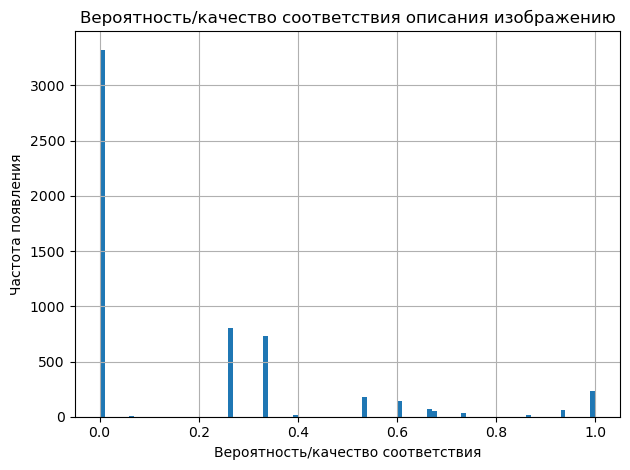

In [13]:
train_w_target.target.hist(bins=100)

plt.title('Вероятность/качество соответствия описания изображению')
plt.xlabel('Вероятность/качество соответствия')
plt.ylabel('Частота появления')
plt.tight_layout()
plt.show()

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная имеет значения от 0 до 1.
Как видим, в большинстве пар изображение-описание описание не соответствует содержанию картинки. Тем не менее, позитивных наблюдений также достаточно для построения модели

## 4. Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Таким образом, удалим из обучающей выборки такие изображения, описания которых содержат упоминания детей.

In [14]:
train_w_target = train_w_target[~train_w_target['image'].isin(train_w_target[train_w_target['query_text']
                                                              .str.contains('child|kid|baby|babies|infant|toddler|newborn|minor|preteen',
                                       case=False, na=False)]['image'].unique())].reset_index(drop=True)



In [15]:
train_w_target

,image,query_text,target
0,2616643090_4f2d2d1a44.jpg,A girl wearing a yellow shirt and sunglasses s...,0.000000
1,2648165716_02e2e74fd6.jpg,A girl wearing a yellow shirt and sunglasses s...,0.000000
2,3503689049_63212220be.jpg,A girl wearing a yellow shirt and sunglasses s...,0.264000
3,3187395715_f2940c2b72.jpg,A man sleeps under a blanket on a city street .,0.330000
4,488590040_35a3e96c89.jpg,A man sleeps under a blanket on a city street .,0.330000
...,...,...,...
3344,757046028_ff5999f91b.jpg,A man in an ampitheater talking to a boy .,0.330667
3345,799486353_f665d7b0f0.jpg,a old man walks down the uncrowded road .,0.000000
3346,909808296_23c427022d.jpg,A dog stands on the side of a grassy cliff .,0.330000
3347,929679367_ff8c7df2ee.jpg,A blurry photo of two dogs .,0.536000


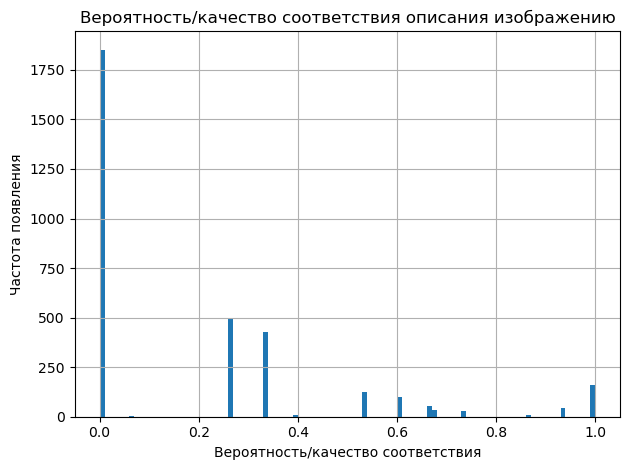

In [16]:
train_w_target.target.hist(bins=100)

plt.title('Вероятность/качество соответствия описания изображению')
plt.xlabel('Вероятность/качество соответствия')
plt.ylabel('Частота появления')
plt.tight_layout()
plt.show()

Так, мы удалили из выборки изображения детей, которые потенциально могут нарушать закон. Отметим, что после удаления таких изображений распределение вероятностей не претерпело значительных изменений.

## 5. Векторизация изображений

Перейдём к векторизации изображений.
Для векторизации будем использовать предобученную модель ResNet18 без последних полносвязных слоев.

In [17]:
# Загрузим модель ResNet18
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False) 

modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)

resnet.add_module("AdaptiveAvgPool", nn.AdaptiveAvgPool2d((1, 1)))


resnet.eval()
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm
]) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
#подготовим вектор уникальных названий изображений и путей к ним
images = train_w_target.image.unique()
pathes = 'train_images/'+images

image_vectorisation = pd.DataFrame(list(zip(images, pathes)), columns = ['image','pathes'])

In [19]:
image_vectorisation['image_vector'] = [None]*len(image_vectorisation['pathes'])

for i,path in enumerate(image_vectorisation['pathes']):
    if i%50==0:
        print(f"{i}/{len(image_vectorisation['pathes'])}")
        
    img = Image.open(path).convert('RGB') 

    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()

    image_vectorisation['image_vector'][i] = output_tensor

0/619
50/619
100/619
150/619
200/619
250/619
300/619
350/619
400/619
450/619
500/619
550/619
600/619


In [20]:
len(output_tensor)

512

In [21]:
display(output_tensor.shape)
image_vectorisation.info()

torch.Size([512])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         619 non-null    object
 1   pathes        619 non-null    object
 2   image_vector  619 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


Итак, для каждого изображения в обучающей выборке мы составили векторное представление из векторов размерностью 25088 при помощи предобученной модели ResNet18.

## 6. Векторизация текстов

Для векторизации тестов описаний получим эмбеддинги с помощью модели BERT

In [22]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model_text = BertModel.from_pretrained(MODEL_NAME)

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model_text(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

In [23]:
#подготовим вектор текстовых описаний
query_vectorisation = pd.DataFrame((train_w_target.query_text.str.lower()).drop_duplicates()).reset_index(drop=True)
query_vectorisation['query_vector'] = [None] * len(query_vectorisation)

In [24]:
for i, text in enumerate(query_vectorisation['query_text']):
    if i%50==0:
        print(f"{i}/{len(query_vectorisation['query_text'])}")

    embedding = get_bert_embedding(text)
    
    query_vectorisation['query_vector'][i] = embedding

0/833
50/833
100/833
150/833
200/833
250/833
300/833
350/833
400/833
450/833
500/833
550/833
600/833
650/833
700/833
750/833
800/833


In [25]:
display(embedding.shape)
query_vectorisation.info()

(768,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query_text    833 non-null    object
 1   query_vector  833 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB


Итак, для каждого описания в обучающей выборке мы составили векторное представление из векторов размерностью 768 при помощи предобученной модели BERT.

## 7. Объединение векторов

Объединим векторные представления текстов и изображений в единый датасет с целевой переменной.

In [26]:
train_w_target['query_text'] = train_w_target['query_text'].str.lower()

dataset = (train_w_target[['image','query_text','target']]
                .merge(image_vectorisation[['image','image_vector']], how = 'left', on = 'image')
                .merge(query_vectorisation[['query_text','query_vector']], how = 'left', on = 'query_text'))


dataset['image_vector'] = dataset.image_vector.apply(lambda x : x.numpy()) 
dataset['features'] = list(np.concatenate([np.stack(dataset['image_vector'].to_numpy()),
                           np.stack(dataset['query_vector'].to_numpy())],
                           axis=1))

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3349 entries, 0 to 3348
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         3349 non-null   object 
 1   query_text    3349 non-null   object 
 2   target        3349 non-null   float64
 3   image_vector  3349 non-null   object 
 4   query_vector  3349 non-null   object 
 5   features      3349 non-null   object 
dtypes: float64(1), object(5)
memory usage: 183.1+ KB


Таким образом мы подготовили набор данных для обучения модели.

## 8. Обучение модели предсказания соответствия


Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Используем групповое разбиение по group_column image_vector, чтобы избежать того, что одно и то же изображение попадает и в обучающую и в валидационную выборку

In [28]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, val_indices = next(gss.split(X=dataset.drop(columns=['image','query_text','image_vector','query_vector','target']),
                                            y=dataset['target'], groups=dataset['image']))
train_df, val_df = dataset.loc[train_indices,['features','target']],dataset.loc[val_indices,['features','target']]


В качестве метрики качества будем исопльзовать Binary Cross-Entropy так как она лучше всего подходит для таргет переменных, по смыслу отражающих вероятность и лежащих в диапазоне от 0 до 1.

In [29]:
# Создание модели
model = Sequential()

model.add(Input(shape=(train_df['features'][0].shape[0],)))

model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))

model.add(Dense(8, activation='relu', kernel_regularizer=l2(1e-4)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['mae'])

In [30]:
X_train = np.array(train_df['features'].tolist())  # Преобразование в numpy массив
X_val = np.array(val_df['features'].tolist())

history = model.fit(
    X_train, train_df['target'],
    validation_data=(X_val, val_df['target']),
    epochs=25,
    batch_size=16
)

Epoch 1/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.6662 - mae: 0.2267 - val_loss: 0.6502 - val_mae: 0.2275
Epoch 2/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.6105 - mae: 0.1987 - val_loss: 0.6274 - val_mae: 0.2120
Epoch 3/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.6038 - mae: 0.1973 - val_loss: 0.6199 - val_mae: 0.1891
Epoch 4/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.5795 - mae: 0.1836 - val_loss: 0.6076 - val_mae: 0.1922
Epoch 5/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5539 - mae: 0.1679 - val_loss: 0.5945 - val_mae: 0.1802
Epoch 6/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.5446 - mae: 0.1653 - val_loss: 0.5960 - val_mae: 0.1806
Epoch 7/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.5374 - mae: 0.1580 - val_loss: 0.5956 - val_mae: 0.1928
Epoch 8/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.5336 - mae: 0.1558 - val_loss: 0.5857 - val_mae: 0.1916
Epoch 9/25
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/

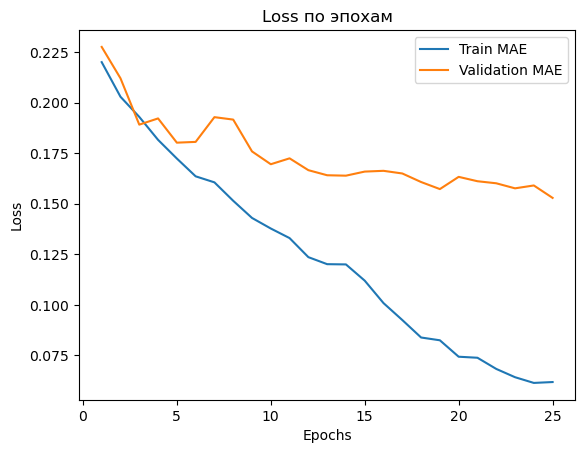

In [31]:
loss = history.history['mae']
val_loss = history.history['val_mae']

# Построение графика
plt.plot(range(1, len(loss) + 1), loss, label='Train MAE')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation MAE')

plt.title('Loss по эпохам')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Как видим, качество модели на тренировочной выборке значительно выросло, в то время как на валидационной также улучшилось, но в меньшей степени.

## 9. Тестирование модели

В первую очередь, для соответствия регуляторным нормам, удалим из тестовой выборки все изображения с детьми.

In [32]:
test_queries = pd.read_csv('test_queries.csv', sep = '|', index_col=0)

test_queries = test_queries[~test_queries['image'].isin(test_queries[test_queries['query_text']
                                                              .str.contains('child|kid|baby|babies|infant|toddler|newborn|minor|preteen',
                                       case=False, na=False)]['image'].unique())].reset_index(drop=True)

Затем,получим векторные представления всех оставшихся тестовых изображений.

In [33]:
test = pd.read_csv('test_images.csv')

test = test[test['image'].isin(test_queries['image'].unique())].reset_index(drop=True)

display(test.head())
test.info()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,424307754_1e2f44d265.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   77 non-null     object
dtypes: object(1)
memory usage: 744.0+ bytes


In [34]:
test['pathes'] = 'test_images/'+test['image']
test['image_vector'] = [None]*len(test['pathes'])

for i,path in enumerate(test['pathes']):
    if i%50==0:
        print(f"{i}/{len(test['pathes'])}")
        
    img = Image.open(path).convert('RGB') 

    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten().numpy()

    test['image_vector'][i] = output_tensor

0/77
50/77


In [35]:
display(output_tensor.shape)
test.info()

(512,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         77 non-null     object
 1   pathes        77 non-null     object
 2   image_vector  77 non-null     object
dtypes: object(3)
memory usage: 1.9+ KB


Векторные представления тестовых изображений получены. Далее перейдем к текстовым описаниям.

Затем, случайным образом отберем 10 запросов и получим для них вектореные представления.

In [36]:
np.random.seed(1)
test_indices = np.random.choice(range(len(test_queries)), size=10, replace=False)
test_indices

array([256, 106, 122,  62, 185, 283, 139,  95, 258, 127])

In [37]:
selected_queries = test_queries.loc[test_indices]
selected_queries

,query_id,query_text,image
256,3466891862_9afde75568.jpg#1,a little white and tan dog running through the...,3466891862_9afde75568.jpg
106,2887171449_f54a2b9f39.jpg#1,A woman with glasses is sewing .,2887171449_f54a2b9f39.jpg
122,3036971334_78187a9570.jpg#2,Four people are cavorting on the rocks at a ri...,3036971334_78187a9570.jpg
62,2448210587_9fe7ea5f42.jpg#2,A white bulldog sitting on a tree stump gives ...,2448210587_9fe7ea5f42.jpg
185,3247693965_845b3b4349.jpg#0,A dog in a harness pulling a pink carrier behi...,3247693965_845b3b4349.jpg
283,3517023411_a8fbd15230.jpg#3,A man with something orange on his helmet ridi...,3517023411_a8fbd15230.jpg
139,3089107423_81a24eaf18.jpg#4,The man in the black shirt is pointing his cam...,3089107423_81a24eaf18.jpg
95,2714674623_8cd05ac114.jpg#0,a large man dozes off on the bus .,2714674623_8cd05ac114.jpg
258,3466891862_9afde75568.jpg#3,The small dog returns with his stick proudly .,3466891862_9afde75568.jpg
127,3044359043_627488ddf0.jpg#2,A dog jumping off a dock into a pool of water .,3044359043_627488ddf0.jpg


In [38]:
# Получим векторное представление для этих описаний
selected_queries = pd.DataFrame(selected_queries.query_text.str.lower()).reset_index(drop=True)
selected_queries['query_vector'] = [None] * len(selected_queries)


for i, text in enumerate(selected_queries['query_text']):
    if i%5==0:
        print(f"{i}/{len(selected_queries['query_text'])}")

    embedding = get_bert_embedding(text)
    
    selected_queries['query_vector'][i] = embedding

0/10
5/10


Теперь, получив 10 случайных описание и их векторное представление, мы составим всевозможные комбинации из 10 выбранных описаний и 77 тестовых изображений (770 штук), для каждой из них рассчитаем вероятность соответствия описания изображению с помощью обученной модели.

In [39]:
combinations = list(product(selected_queries.itertuples(index=False, name=None),
                            test.itertuples(index=False, name=None)))

test_features = pd.DataFrame([(a, b, c, d, e) for (a, b), (c,d,e) in combinations],
                              columns=['query_text', 'query_vector','image','pathes', 'image_vector'])

test_features['features'] = list(np.concatenate([np.stack(test_features['image_vector'].to_numpy()),
                           np.stack(test_features['query_vector'].to_numpy())],
                           axis=1))

test_features = test_features.drop(columns = ['query_vector','image_vector','pathes'], axis=1)

In [40]:
y_pred = model.predict(np.array(test_features['features'].tolist()))

test_features['proba_predicted'] = y_pred

best_test_featueres = test_features.loc[test_features.groupby('query_text')['proba_predicted'].idxmax()].reset_index(drop=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Визуально рассмотрим получившиеся соответствия.

Found 10 validated image filenames.


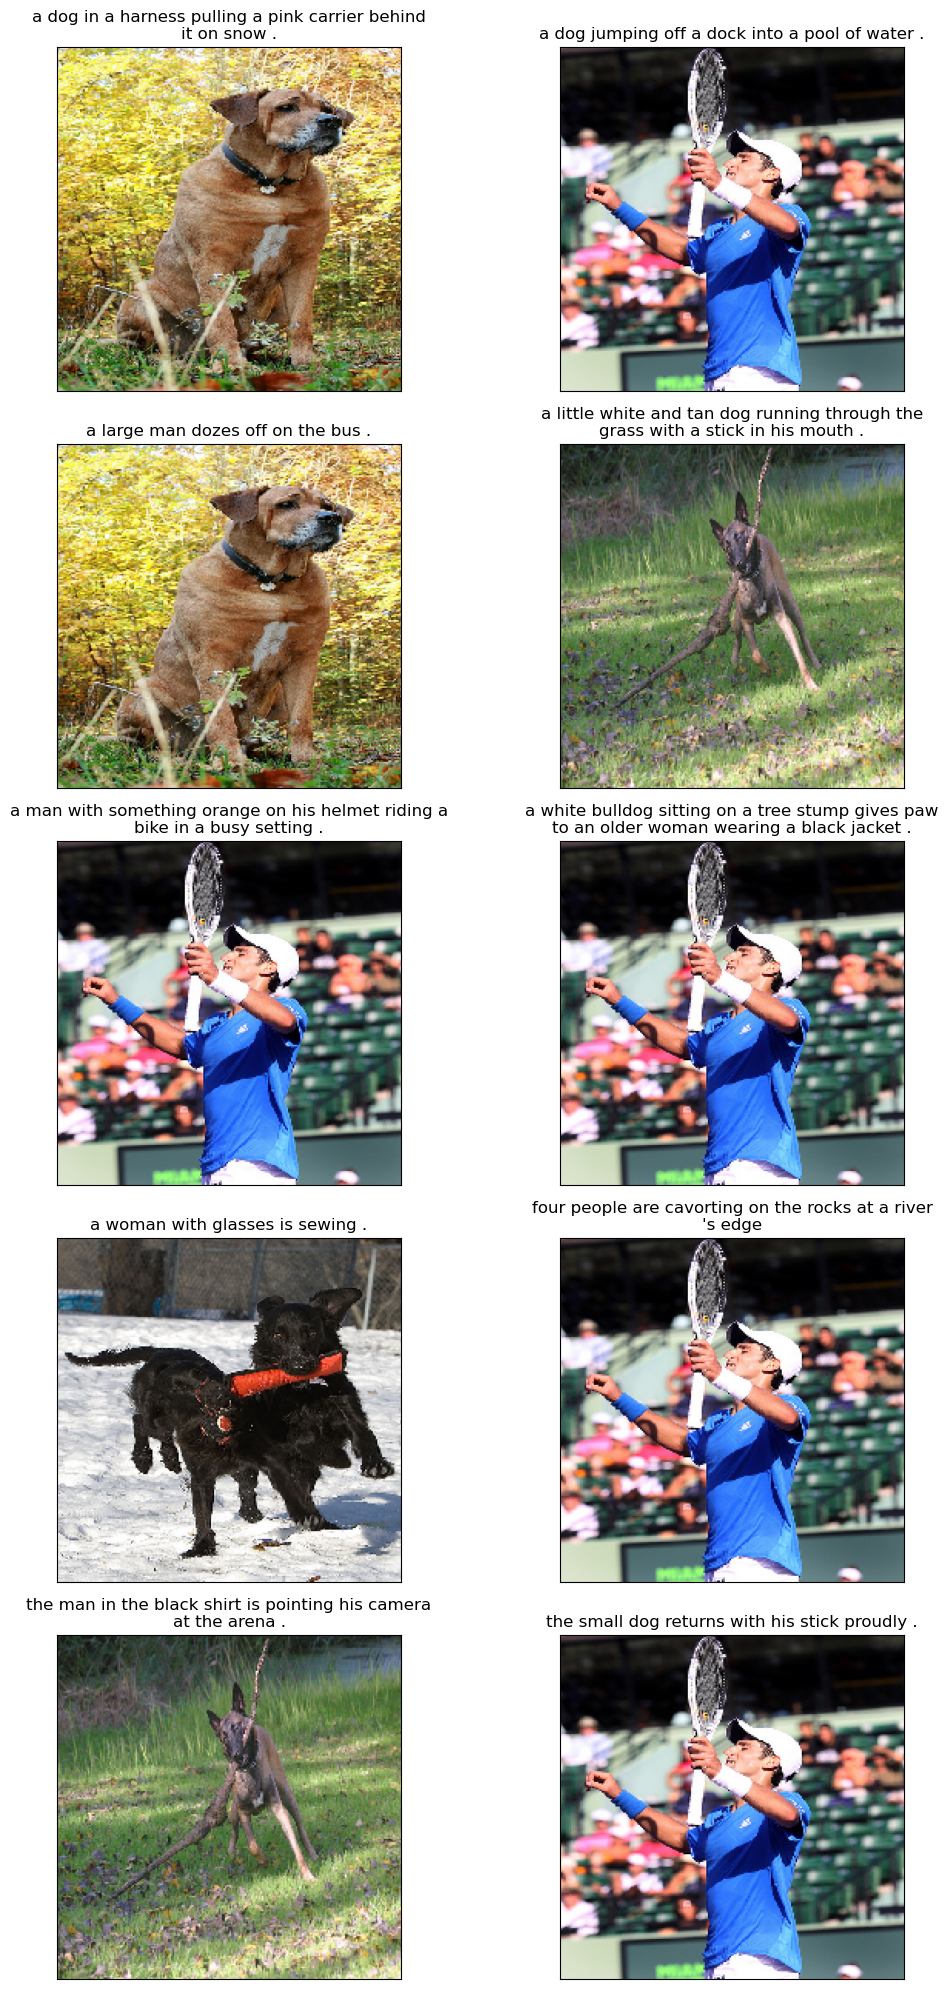

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255)

gen_flow = train_datagen.flow_from_dataframe(
        dataframe=best_test_featueres,
        directory='test_images/',
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=10,
        class_mode=None,
        seed=12345) 

features = next(gen_flow)

fig = plt.figure(figsize=(15,20))
for i in range(10):
    fig.add_subplot(5, 2, i+1)
    #plt.title(best_test_featueres['query_text'][i])
    wrapped_title = "\n".join(textwrap.wrap(best_test_featueres['query_text'][i], width=50))
    plt.title(wrapped_title)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

К сожалению, мы видим, что далеко не всегда изображения и описания соответствуют друг другу. На многих изображениях можно узнать некоторые элементы из описания и понять, почему модель определила именно такое соответствие, однако для промышленного использования данного подхода необходимо дополнительное исследование.

## 10. Выводы

В рамках данного проекта мы посмотроили предвариетельную модель, которая рассчитывает верояттность/степень сооветствия описания и изображения. Данная модель может быть использована для поиска релевантных изображений для заданного описания. К сожалению, на этапе MVP достигнуть отличных результатов не удалось - качества подбора изображений достаточно низкое, совпадают отдельные элементы изображений. В дальнейшем модель может быть развита.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска